In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import codes.data_utils
import importlib

importlib.reload(codes.data_utils)
from codes.data_utils import set_seed

set_seed(42)
# Load centrality data
centrality_df = pd.read_excel("data/Centrality_indices.xlsx")

In [2]:
clean_cities_df = centrality_df
clean_city_ids = set(clean_cities_df['Codmundv'].astype(int).unique())
len(clean_city_ids)

5386

In [3]:
pop_df = pd.read_csv("data/cleaned_population_2022.csv")
scaler = MinMaxScaler()
pop_df_filtered = pop_df[pop_df["ibgeID"].isin(clean_city_ids)].copy()
pop_df_filtered["Population_2025_Normalized"] = scaler.fit_transform(pop_df_filtered[["population"]])

In [4]:
import codes.extract_backbone

importlib.reload(codes.extract_backbone)
from codes.extract_backbone import extract_backbone_from_files_brazil

backbone_df, backbone_cities = extract_backbone_from_files_brazil(
    centrality_path="data/Centrality_indices.xlsx",
    mobility_edges_path="data/Road_and_waterway_connections_database_2016.xlsx",
    alpha=0.01,
    city_whitelist=clean_city_ids
)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df[['source', 'target', 'weekly_flow', 'pij']].head())

[✓] Backbone extracted and saved to 'data/mobility_backbone_brazil.csv'.
Backbone extracted with 20057 edges
    source   target  weekly_flow       pij
0  1302603  1304260          7.5  0.624295
1  1302108  1302603          3.0  0.678201
2  5103809  5108402          0.0  1.000000
3  1300029  1302603          7.5  0.732111
4  1300029  1301308          6.0  0.728335


In [5]:
pop_df_filtered = pop_df_filtered[pop_df_filtered["ibgeID"].isin(backbone_cities)]

In [6]:
from codes.graph_utils import build_pyg_graph_from_backbone

pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city, 0.0) for city in backbone_cities]

centrality_df = centrality_df[centrality_df['Codmundv'].isin(backbone_cities)].copy()
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)
pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)
print(pyg_data)

[✓] Graph built with 5383 nodes and 20057 edges.
[✓] Converted to PyTorch Geometric format.
Data(edge_index=[2, 40114], name=[5383], weight=[40114], edge_attr=[40114, 1], num_nodes=5383, x=[5383, 1])


In [7]:
import numpy as np
from codes.load_and_save_covid_data import load_and_save_covid_data

covid_df = load_and_save_covid_data()
covid_df = covid_df[covid_df["ibgeID"].isin(backbone_cities)]

print(f"Full date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Total records: {len(covid_df):,}")

negative_counts = (covid_df.select_dtypes(include=[np.number]) < 0).sum()
print("📉 Negative values per column:")
print(negative_counts[negative_counts > 0])


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Full date range: 2020-02-25 00:00:00 to 2023-03-18 00:00:00
Total records: 5,608,998
📉 Negative values per column:
newDeaths    14742
newCases     59784
dtype: int64


In [8]:
import codes.preprocess_covid_brazil
importlib.reload(codes.preprocess_covid_brazil)
from codes.preprocess_covid_brazil import filter_and_scale_covid_by_centrality

filtered_scaled_covid_df = filter_and_scale_covid_by_centrality(covid_df, city_whitelist=backbone_cities)

[✓] Filtered to 5383 cities, 5,608,998 rows.
[✓] Negative values in 'newCases' and 'newDeaths' clipped to 0.
[✓] Computed cases and deaths per 100,000 population.
[✓] Applied Z-score normalization.
[✓] Saved filtered + scaled COVID data to 'data/filtered_scaled_covid.csv'.


In [9]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [10]:
from codes.data_utils import prepare_temporal_graph_data_non_overlapping, generate_sliding_temporal_graph_data, \
    prepare_temporal_graph_data_non_overlapping

# Traditional (non-sliding) approach
X_train_static, X_test_static, Y_train_static, Y_test_static = prepare_temporal_graph_data_non_overlapping(
    filtered_scaled_covid_df,
    sequence_length=15,
    feature_column="z_newCases",
    device=device
)

# Sliding window approach
X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    filtered_scaled_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device
)

Y_train_slide = Y_train_slide.squeeze(1)
print(Y_train_slide.shape)

Y_test_slide = Y_test_slide.squeeze(1)
print(Y_test_slide.shape)

# Compare number of samples
total_static = len(X_train_static) + len(X_test_static)
total_slide = len(X_train_slide) + len(X_test_slide)

print("📊 Sample Count Comparison")
print(f"Static window (15 input, 1 output): {total_static} samples")
print(f"Sliding window (10 input, 1 output): {total_slide} samples")
print(f"⬆️ Gain: {total_slide - total_static} samples (+{100 * (total_slide - total_static) / total_static:.2f}%)")


[📉] (Non-overlapping) X shape: torch.Size([69, 15, 5383, 1]) | Y shape: torch.Size([69, 5383, 1])
[📉] Train: torch.Size([55, 15, 5383, 1]) | Test: torch.Size([14, 15, 5383, 1])
[✓] Sliding window: X torch.Size([1104, 14, 5383, 1]), Y torch.Size([1104, 1, 5383, 1])
[✓] Train: torch.Size([883, 14, 5383, 1]), Test: torch.Size([221, 14, 5383, 1])
torch.Size([883, 5383, 1])
torch.Size([221, 5383, 1])
📊 Sample Count Comparison
Static window (15 input, 1 output): 69 samples
Sliding window (10 input, 1 output): 1104 samples
⬆️ Gain: 1035 samples (+1500.00%)


In [11]:
import codes.models.custom_gcn_transformer_parallel
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcn_transformer_parallel)

from codes.models.custom_gcn_transformer_parallel import SpatioTemporalFusionNet

N = pyg_data.num_nodes

model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=1,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=64,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.7) 

In [12]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [13]:
batch_size = 16  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [15]:
model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=1,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=64,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

model.load_state_dict(torch.load("models/Brazil-Experiment-Non-Cleaned-Local-Transformer-Attempt-1.pth"))
model.eval()

SpatioTemporalFusionNet(
  (node_embedding): Embedding(5383, 1)
  (spatial_encoder): GCNEncoder(
    (gcn1): GCNConv(1, 64)
    (gcn2): GCNConv(64, 64)
    (relu): ReLU()
  )
  (temporal_encoder): TemporalTransformer(
    (proj): Linear(in_features=1, out_features=64, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
   

In [17]:
num_epochs = 10
batch_size_nodes = 500  # Adjust based on GPU capability
num_nodes = N  # 5383 nodes total

In [33]:
from torch_geometric.utils import subgraph
from tqdm import tqdm

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"🧠 Epoch {epoch+1}/{num_epochs}")

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        node_losses = 0.0
            num_node_batches = 0

        for node_start in range(0, num_nodes, batch_size_nodes):
            node_end = min(node_start + batch_size_nodes, num_nodes)
            node_indices = torch.arange(node_start, node_end, device=device)

            # Subset node data
            batch_X_nodes = batch_X[:, :, node_start:node_end, :]
            batch_Y_nodes = batch_Y[:, node_start:node_end, :]

            # Subset edge_index
            edge_index_sub, edge_weight_sub = subgraph(
                node_indices, edge_index, edge_weight,
                relabel_nodes=True, num_nodes=num_nodes
            )

            # **Zero gradients per node-batch**
            optimizer.zero_grad()

            # Forward and backward pass
            output = model(batch_X_nodes, edge_index_sub, edge_weight_sub, node_indices=node_indices)
            batch_loss = criterion(output, batch_Y_nodes)
            batch_loss.backward()

            # **Optimizer step per node-batch**
            optimizer.step()

            # Track loss
            node_losses += batch_loss.item()
            num_node_batches += 1

        # Average loss over node-batches for current global batch
        avg_node_loss = node_losses / num_node_batches
        total_loss += avg_node_loss

        pbar.set_postfix({"Loss": f"{avg_node_loss:.4f}"})

    avg_epoch_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_epoch_loss:.4f}")
    scheduler.step()


🧠 Epoch 1/10: 100%|██████████| 56/56 [18:55<00:00, 20.27s/it, Loss=0.4740]


✅ Epoch 1/10 — Avg Loss: 0.8659


🧠 Epoch 2/10: 100%|██████████| 56/56 [18:09<00:00, 19.46s/it, Loss=0.3898]


✅ Epoch 2/10 — Avg Loss: 0.8609


🧠 Epoch 3/10: 100%|██████████| 56/56 [18:49<00:00, 20.17s/it, Loss=2.5392]


✅ Epoch 3/10 — Avg Loss: 0.8929


🧠 Epoch 4/10: 100%|██████████| 56/56 [18:57<00:00, 20.31s/it, Loss=0.8263]


✅ Epoch 4/10 — Avg Loss: 0.8639


🧠 Epoch 5/10: 100%|██████████| 56/56 [19:04<00:00, 20.43s/it, Loss=1.0799]


✅ Epoch 5/10 — Avg Loss: 0.8667


🧠 Epoch 6/10: 100%|██████████| 56/56 [18:18<00:00, 19.62s/it, Loss=0.5535]


✅ Epoch 6/10 — Avg Loss: 0.8706


🧠 Epoch 7/10: 100%|██████████| 56/56 [18:14<00:00, 19.54s/it, Loss=0.1578]


✅ Epoch 7/10 — Avg Loss: 0.8573


🧠 Epoch 8/10: 100%|██████████| 56/56 [18:52<00:00, 20.22s/it, Loss=1.1404]


✅ Epoch 8/10 — Avg Loss: 0.8712


🧠 Epoch 9/10: 100%|██████████| 56/56 [19:09<00:00, 20.53s/it, Loss=0.9249]


✅ Epoch 9/10 — Avg Loss: 0.8630


🧠 Epoch 10/10: 100%|██████████| 56/56 [17:03<00:00, 18.27s/it, Loss=0.3440]

✅ Epoch 10/10 — Avg Loss: 0.8535


In [18]:
from tqdm import tqdm
from torch_geometric.utils import subgraph

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        batch_pred = []
        batch_actual = []
        node_losses = 0.0
        num_node_batches = 0

        for node_start in range(0, num_nodes, batch_size_nodes):
            node_end = min(node_start + batch_size_nodes, num_nodes)
            node_indices = torch.arange(node_start, node_end, device=device)

            # Slice node-wise input/output
            batch_X_nodes = batch_X[:, :, node_start:node_end, :]
            batch_Y_nodes = batch_Y[:, node_start:node_end, :]

            # Slice graph edges
            edge_index_sub, edge_weight_sub = subgraph(
                node_indices, edge_index, edge_weight,
                relabel_nodes=True, num_nodes=num_nodes
            )

            # Forward pass
            output = model(batch_X_nodes, edge_index_sub, edge_weight_sub, node_indices=node_indices)

            loss = criterion(output, batch_Y_nodes)
            node_losses += loss.item()
            num_node_batches += 1

            # Store for later
            batch_pred.append(output.cpu())
            batch_actual.append(batch_Y_nodes.cpu())

        # Aggregate loss and predictions
        avg_node_loss = node_losses / num_node_batches
        test_loss += avg_node_loss

        predictions.append(torch.cat(batch_pred, dim=1))  # [B, N_chunk, 1] → [B, N, 1]
        actuals.append(torch.cat(batch_actual, dim=1))    # [B, N_chunk, 1] → [B, N, 1]

        progress_bar.set_postfix({"Loss": f"{avg_node_loss:.4f}"})

# Final aggregation
predictions = torch.cat(predictions, dim=0)  # [total_samples, N, 1]
actuals = torch.cat(actuals, dim=0)          # [total_samples, N, 1]

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.4791


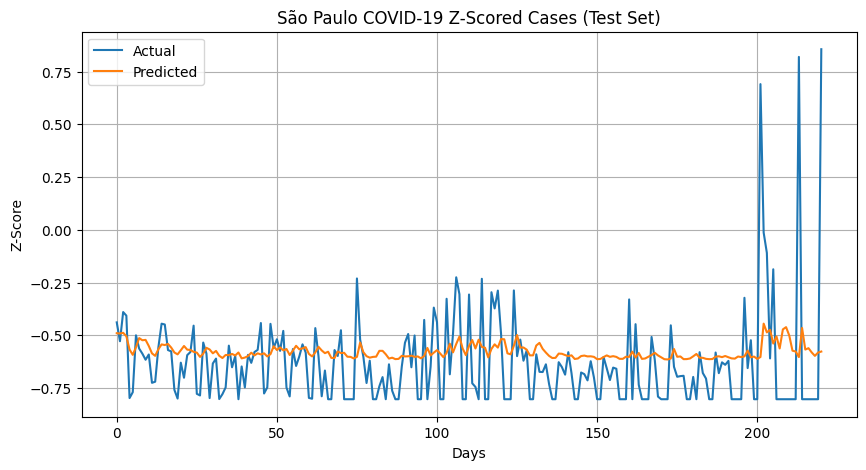

📉 RMSE for São Paulo: 0.2325


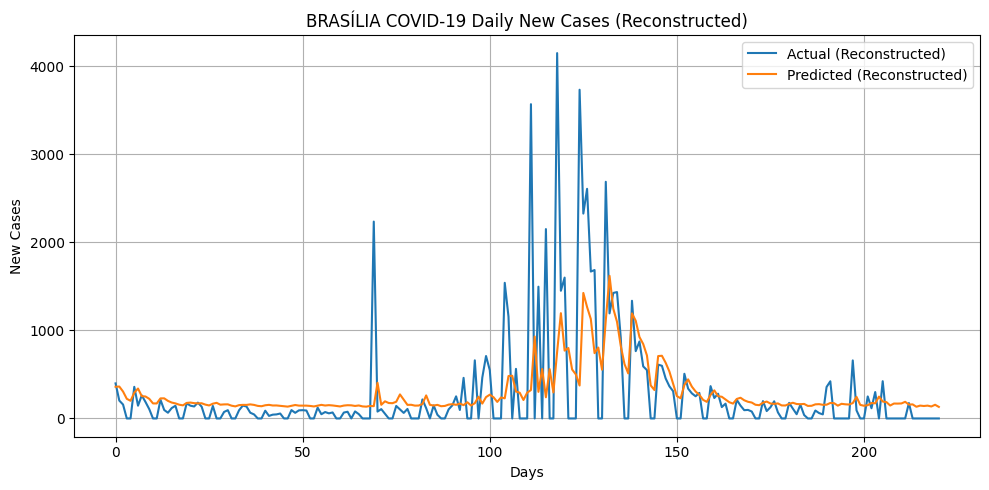

📉 RMSE for BRASÍLIA (Reconstructed): 528.25
📉 SMAPE for SP: 57.72%
📈 MDA for SP: 39.55%


In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)


sp_preds_z = pred_array[:, sp_index]
sp_actuals_z = actual_array[:, sp_index]

# 🧠 Get mean and std from original covid_df
sp_original = covid_df[covid_df['ibgeID'] == sp_code].copy()
sp_original['newCases'] = sp_original['newCases'].clip(lower=0)
sp_original = sp_original.sort_values('date')
mean_sp = sp_original['newCases'].mean()
std_sp = sp_original['newCases'].std(ddof=0)

# 🔁 Reconstruct original values
sp_preds = sp_preds_z * std_sp + mean_sp
sp_actuals = sp_actuals_z * std_sp + mean_sp

# 📈 Plot reconstructed
plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual (Reconstructed)')
plt.plot(sp_preds, label='Predicted (Reconstructed)')
plt.title("BRASÍLIA COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("./figures/local_transformer_brasilia_non_cleaned.png", dpi=300)
plt.show()

# 📉 RMSE in original scale
rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for BRASÍLIA (Reconstructed): {rmse_sp:.2f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
         np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )


def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)


smape_sp = smape(sp_actuals, sp_preds)
print(f"📉 SMAPE for SP: {smape_sp:.2f}%")

mda_sp = mean_directional_accuracy(sp_actuals, sp_preds)
print(f"📈 MDA for SP: {mda_sp:.2f}%")


In [21]:
# Filter BRASÍLIA full series
sp_full = filtered_scaled_covid_df[filtered_scaled_covid_df['ibgeID'] == sp_code].sort_values('date')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['date'].tolist()


In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")

# Calculate SMAPE for each city
smapes = []
for i in range(num_cities):
    smape_i = smape(actual_array[:, i], pred_array[:, i])
    smapes.append(smape_i)

# Compute average SMAPE
avg_smape = np.mean(smapes)
print(f"📊 Average SMAPE across all cities: {avg_smape:.2f}%")

mdas = []
for i in range(num_cities):
    mda_i = mean_directional_accuracy(actual_array[:, i], pred_array[:, i])
    mdas.append(mda_i)

# Compute average MDA
avg_mda = np.mean(mdas)
print(f"📈 Average MDA across all cities: {avg_mda:.2f}%")


📊 Average RMSE across all cities: 0.4893
📊 Average SMAPE across all cities: 19.41%
📈 Average MDA across all cities: 9.99%


In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Map: city code → population
pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["population"]))

rmse_per_100k_list = []

print(len(backbone_cities))

for i, city_code in enumerate(backbone_cities):
    if city_code not in pop_dict:
        continue  # skip if population not found

    # Get predictions and labels (standardized)
    pred_z = pred_array[:, i]
    actual_z = actual_array[:, i]

    # Restore real case counts from z-score
    city_df = covid_df[covid_df['ibgeID'] == city_code].copy()
    city_df['newCases'] = city_df['newCases'].clip(lower=0).sort_values()

    mean_city = city_df['newCases'].mean()
    std_city = city_df['newCases'].std(ddof=0)

    pred_real = pred_z * std_city + mean_city
    actual_real = actual_z * std_city + mean_city

    # Convert to cases per 100k
    population = pop_dict[city_code]
    
    pred_per_100k = pred_real / population * 100000
    actual_per_100k = actual_real / population * 100000

    # Compute RMSE per 100k
    rmse = np.sqrt(mean_squared_error(actual_per_100k, pred_per_100k))
        
    rmse_per_100k_list.append(rmse)

# Average across all cities
avg_rmse_per_100k = np.mean(rmse_per_100k_list)
print(f"📉 Average RMSE per 100k population: {avg_rmse_per_100k:.2f}")


5383
📉 Average RMSE per 100k population: 62.78


In [43]:
rmses_per_100k = []
pop_df = pd.read_csv("data/cleaned_population_2022.csv")

for i, city_id in enumerate(city_id_list):
    city_preds_z = pred_array[:, i]
    city_actuals_z = actual_array[:, i]
    
    # Get mean, std, and population
    city_data = covid_df[covid_df['ibgeID'] == city_id].copy()
    city_data['newCases'] = city_data['newCases'].clip(lower=0)
    mean = city_data['newCases'].mean()
    std = city_data['newCases'].std(ddof=0)
    
    pop = pop_df[pop_df['ibgeID'] == city_id]['population'].values
    if len(pop) == 0 or pd.isna(std) or std == 0:
        continue  # skip missing data or constant series
    
    population = pop[0]

    # Reconstruct actual values and normalize
    preds = city_preds_z * std + mean
    actuals = city_actuals_z * std + mean

    preds_per_100k = (preds / population) * 1e5
    actuals_per_100k = (actuals / population) * 1e5

    # RMSE per 100k
    rmse = np.sqrt(mean_squared_error(actuals_per_100k, preds_per_100k))
    rmses_per_100k.append(rmse)

avg_rmse_per_100k = np.mean(rmses_per_100k)
print(f"📊 Average RMSE across all cities (per 100k): {avg_rmse_per_100k:.4f}")


📊 Average RMSE across all cities (per 100k): 133.0085


In [44]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: 2611606 — RMSE: 2.2367
City ID: 2607901 — RMSE: 2.2285
City ID: 2604106 — RMSE: 2.2256
City ID: 2611101 — RMSE: 2.2224
City ID: 2606200 — RMSE: 2.2193

✅ Top 5 cities with lowest RMSE:
City ID: 3117306 — RMSE: 0.0010
City ID: 2110708 — RMSE: 0.0034
City ID: 2104206 — RMSE: 0.0040
City ID: 3147006 — RMSE: 0.0073
City ID: 3154507 — RMSE: 0.0090


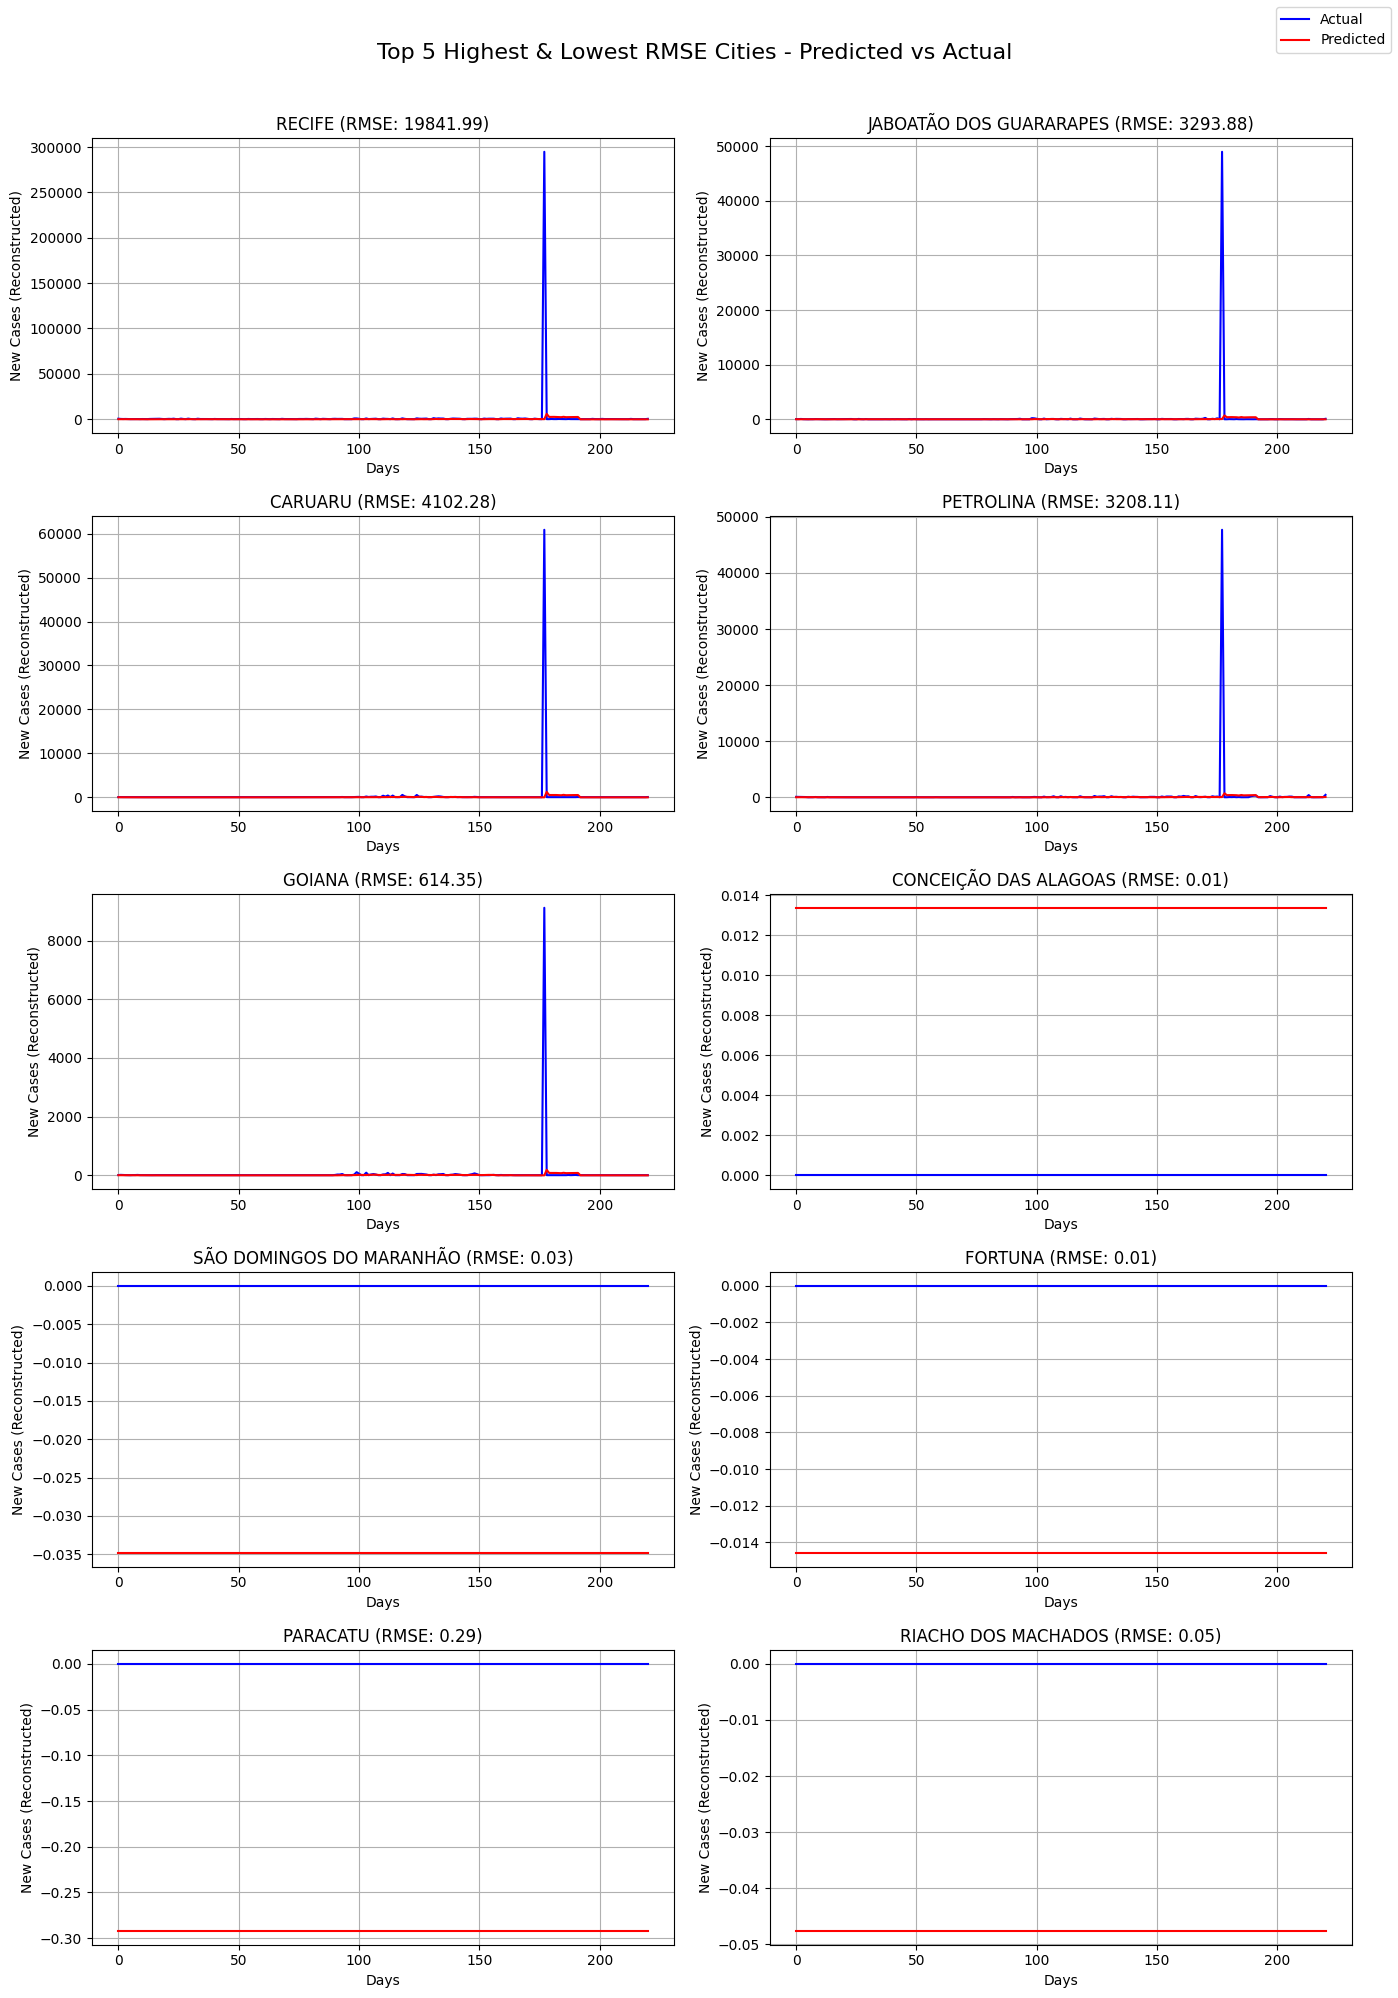

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = covid_df[covid_df['ibgeID'] == city_id].copy()
    city_data['newCases'] = city_data['newCases'].clip(lower=0)
    mean = city_data['newCases'].mean()
    std = city_data['newCases'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [46]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/Brazil-Experiment-Non-Cleaned-Local-Transformer-Attempt-1.pth")